# **TUGAS PBA TERAKHIR FastText**


## **Running sekali**

In [30]:
!pip install torchinfo

In [31]:
import pandas as pd
import numpy as np
import torch
import time
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torchinfo import summary

In [9]:
# Cek device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device yang digunakan: {DEVICE}")

Device yang digunakan: cuda


In [23]:
# Path Dataset
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
GLOVE_PATH = "/content/glove.6B.100d.txt"  # Sesuaikan path Anda
EMBEDDING_DIM = 100

# Load Dataset
train_df = pd.read_csv(TRAIN_PATH, header=None, names=["class", "title", "description"])
test_df = pd.read_csv(TEST_PATH, header=None, names=["class", "title", "description"])

# Gabungkan title dan description
train_df["text"] = train_df["title"].fillna("") + ". " + train_df["description"].fillna("")
test_df["text"] = test_df["title"].fillna("") + ". " + test_df["description"].fillna("")

# Encode label
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["class"])
test_df["label"] = label_encoder.transform(test_df["class"])

# Load GloVe pre-trained embeddings
def load_glove_embeddings(glove_path, embedding_dim):
    word_to_idx = {"<PAD>": 0, "<UNK>": 1}
    embedding_matrix = [np.zeros(embedding_dim), np.random.uniform(-0.25, 0.25, embedding_dim)]

    print("Memuat GloVe embeddings...")
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)

            # Validasi dimensi embedding
            if vector.shape[0] != embedding_dim:
                print(f"Skipping word {word} due to dimension mismatch: expected {embedding_dim}, got {vector.shape[0]}")
                continue

            word_to_idx[word] = len(word_to_idx)
            embedding_matrix.append(vector)

    embedding_matrix = np.array(embedding_matrix)
    print("GloVe embeddings telah berhasil dimuat!")
    return word_to_idx, torch.tensor(embedding_matrix, dtype=torch.float)

word_to_idx, embedding_matrix = load_glove_embeddings(GLOVE_PATH, EMBEDDING_DIM)
print("Ukuran Embedding matrix:", embedding_matrix.shape)

Memuat GloVe embeddings...
Skipping word 241.5 due to dimension mismatch: expected 100, got 76
GloVe embeddings telah berhasil dimuat!
Ukuran Embedding matrix: torch.Size([254745, 100])


In [24]:
# Dataset
class FastTextDataset(Dataset):
    def __init__(self, texts, labels, word_to_idx, max_len):
        self.texts = texts
        self.labels = labels
        self.word_to_idx = word_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        tokens = text.split()
        token_ids = [self.word_to_idx.get(token, 1) for token in tokens]  # 1 = "<UNK>"
        if len(token_ids) < self.max_len:
            token_ids += [0] * (self.max_len - len(token_ids))  # 0 = "<PAD>"
        else:
            token_ids = token_ids[:self.max_len]

        return {
            "input_ids": torch.tensor(token_ids, dtype=torch.long),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Dataset dan DataLoader
MAX_LEN = 100
train_dataset = FastTextDataset(train_df["text"].values, train_df["label"].values, word_to_idx, MAX_LEN)
test_dataset = FastTextDataset(test_df["text"].values, test_df["label"].values, word_to_idx, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [25]:
# Model
class FastTextClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, n_classes):
        super(FastTextClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.fc1 = nn.Linear(EMBEDDING_DIM, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)
        pooled = embeddings.mean(dim=1)  # Mean pooling
        hidden = torch.relu(self.fc1(pooled))
        hidden = self.dropout(hidden)
        return self.fc2(hidden)

# Inisialisasi Model
model = FastTextClassifier(
    embedding_matrix=embedding_matrix,
    hidden_size=128,
    n_classes=len(label_encoder.classes_)
).to(DEVICE)

# Optimizer dan Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_epoch(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in data_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

In [32]:
summary(model)

Layer (type:depth-idx)                   Param #
FastTextClassifier                       --
├─Embedding: 1-1                         (25,474,500)
├─Linear: 1-2                            12,928
├─Linear: 1-3                            516
├─Dropout: 1-4                           --
Total params: 25,487,944
Trainable params: 13,444
Non-trainable params: 25,474,500

In [33]:
# Evaluasi
def evaluate(model, data_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return accuracy_score(true_labels, predictions)

In [34]:
# Train Model
EPOCHS = 3

for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    acc = evaluate(model, test_loader)
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Accuracy: {acc:.4f}, Durasi: {epoch_duration:.2f} detik")


Epoch 1: Train Loss: 1.0096, Test Accuracy: 0.7825, Durasi: 13.62 detik
Epoch 2: Train Loss: 0.6475, Test Accuracy: 0.7993, Durasi: 12.44 detik
Epoch 3: Train Loss: 0.5822, Test Accuracy: 0.8076, Durasi: 13.87 detik


In [35]:
# Save Model
torch.save(model.state_dict(), "fasttext_glove_model.pth")
print("Model berhasil disimpan!")

Model berhasil disimpan!


## **Running 2 kali**

In [ ]:
!pip install torchinfo

In [48]:
import pandas as pd
import numpy as np
import torch
import time
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torchinfo import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [37]:
# Cek device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device yang digunakan: {DEVICE}")

Device yang digunakan: cuda


In [38]:
# Path Dataset
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
GLOVE_PATH = "/content/glove.6B.100d.txt"  # Sesuaikan path Anda
EMBEDDING_DIM = 100

# Load Dataset
train_df = pd.read_csv(TRAIN_PATH, header=None, names=["class", "title", "description"])
test_df = pd.read_csv(TEST_PATH, header=None, names=["class", "title", "description"])

# Gabungkan title dan description
train_df["text"] = train_df["title"].fillna("") + ". " + train_df["description"].fillna("")
test_df["text"] = test_df["title"].fillna("") + ". " + test_df["description"].fillna("")

# Encode label
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["class"])
test_df["label"] = label_encoder.transform(test_df["class"])

# Load GloVe pre-trained embeddings
def load_glove_embeddings(glove_path, embedding_dim):
    word_to_idx = {"<PAD>": 0, "<UNK>": 1}
    embedding_matrix = [np.zeros(embedding_dim), np.random.uniform(-0.25, 0.25, embedding_dim)]

    print("Memuat GloVe embeddings...")
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)

            # Validasi dimensi embedding
            if vector.shape[0] != embedding_dim:
                print(f"Skipping word {word} due to dimension mismatch: expected {embedding_dim}, got {vector.shape[0]}")
                continue

            word_to_idx[word] = len(word_to_idx)
            embedding_matrix.append(vector)

    embedding_matrix = np.array(embedding_matrix)
    print("GloVe embeddings telah berhasil dimuat!")
    return word_to_idx, torch.tensor(embedding_matrix, dtype=torch.float)

word_to_idx, embedding_matrix = load_glove_embeddings(GLOVE_PATH, EMBEDDING_DIM)
print("Ukuran Embedding matrix:", embedding_matrix.shape)

Memuat GloVe embeddings...
Skipping word 241.5 due to dimension mismatch: expected 100, got 76
GloVe embeddings telah berhasil dimuat!
Ukuran Embedding matrix: torch.Size([254745, 100])


In [39]:
# Dataset
class FastTextDataset(Dataset):
    def __init__(self, texts, labels, word_to_idx, max_len):
        self.texts = texts
        self.labels = labels
        self.word_to_idx = word_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        tokens = text.split()
        token_ids = [self.word_to_idx.get(token, 1) for token in tokens]  # 1 = "<UNK>"
        if len(token_ids) < self.max_len:
            token_ids += [0] * (self.max_len - len(token_ids))  # 0 = "<PAD>"
        else:
            token_ids = token_ids[:self.max_len]

        return {
            "input_ids": torch.tensor(token_ids, dtype=torch.long),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Dataset dan DataLoader
MAX_LEN = 100
train_dataset = FastTextDataset(train_df["text"].values, train_df["label"].values, word_to_idx, MAX_LEN)
test_dataset = FastTextDataset(test_df["text"].values, test_df["label"].values, word_to_idx, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

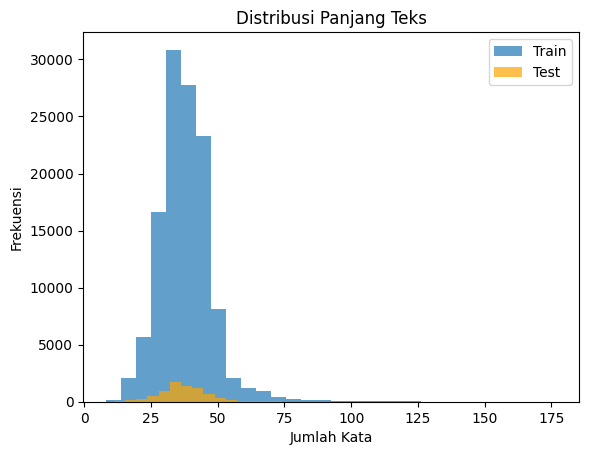

Rata-rata panjang teks Train: 37.85, Max: 177
Rata-rata panjang teks Test: 37.72, Max: 137


In [40]:
train_lengths = train_df["text"].apply(lambda x: len(x.split()))
test_lengths = test_df["text"].apply(lambda x: len(x.split()))

plt.hist(train_lengths, bins=30, alpha=0.7, label="Train")
plt.hist(test_lengths, bins=30, alpha=0.7, label="Test", color='orange')
plt.title("Distribusi Panjang Teks")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()

print(f"Rata-rata panjang teks Train: {train_lengths.mean():.2f}, Max: {train_lengths.max()}")
print(f"Rata-rata panjang teks Test: {test_lengths.mean():.2f}, Max: {test_lengths.max()}")

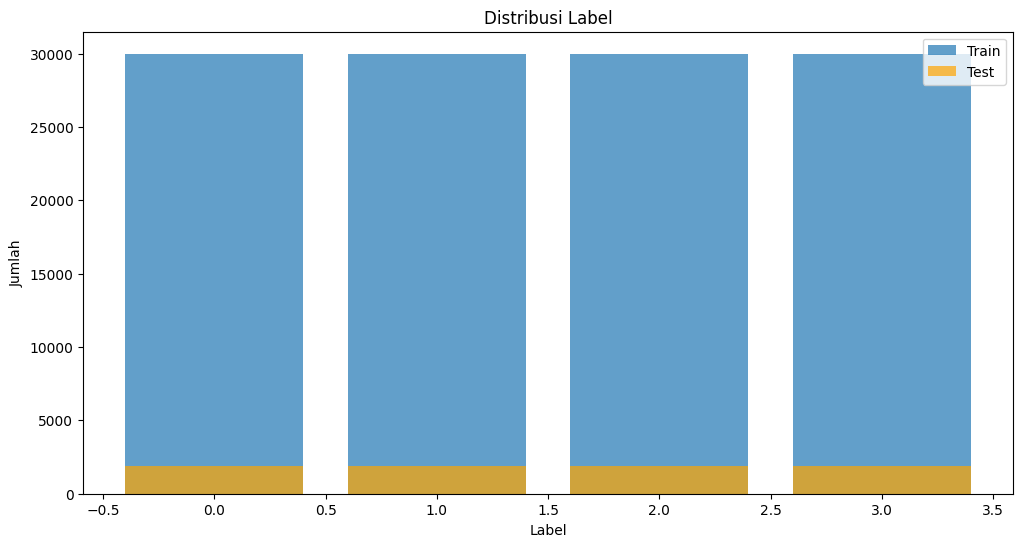

In [41]:
# Distribusi label
train_label_counts = train_df["label"].value_counts()
test_label_counts = test_df["label"].value_counts()

# Visualisasi distribusi label
plt.figure(figsize=(12, 6))
plt.bar(train_label_counts.index, train_label_counts.values, alpha=0.7, label='Train')
plt.bar(test_label_counts.index, test_label_counts.values, alpha=0.7, label='Test', color='orange')
plt.title("Distribusi Label")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.legend()
plt.show()

In [42]:
# Model
class FastTextClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, n_classes):
        super(FastTextClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.fc1 = nn.Linear(EMBEDDING_DIM, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)
        pooled = embeddings.mean(dim=1)  # Mean pooling
        hidden = torch.relu(self.fc1(pooled))
        hidden = self.dropout(hidden)
        return self.fc2(hidden)

# Inisialisasi Model
model = FastTextClassifier(
    embedding_matrix=embedding_matrix,
    hidden_size=128,
    n_classes=len(label_encoder.classes_)
).to(DEVICE)

# Optimizer dan Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_epoch(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in data_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

In [43]:
summary(model)

Layer (type:depth-idx)                   Param #
FastTextClassifier                       --
├─Embedding: 1-1                         (25,474,500)
├─Linear: 1-2                            12,928
├─Linear: 1-3                            516
├─Dropout: 1-4                           --
Total params: 25,487,944
Trainable params: 13,444
Non-trainable params: 25,474,500

In [44]:
# Evaluasi
def evaluate(model, data_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return accuracy_score(true_labels, predictions)

In [45]:
# Train Model
EPOCHS = 10

for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    acc = evaluate(model, test_loader)
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Accuracy: {acc:.4f}, Durasi: {epoch_duration:.2f} detik")


Epoch 1: Train Loss: 1.0360, Test Accuracy: 0.7750, Durasi: 12.07 detik
Epoch 2: Train Loss: 0.6645, Test Accuracy: 0.7966, Durasi: 11.26 detik
Epoch 3: Train Loss: 0.5927, Test Accuracy: 0.8051, Durasi: 11.26 detik
Epoch 4: Train Loss: 0.5642, Test Accuracy: 0.8133, Durasi: 11.20 detik
Epoch 5: Train Loss: 0.5453, Test Accuracy: 0.8166, Durasi: 10.08 detik
Epoch 6: Train Loss: 0.5326, Test Accuracy: 0.8195, Durasi: 11.06 detik
Epoch 7: Train Loss: 0.5227, Test Accuracy: 0.8241, Durasi: 11.22 detik
Epoch 8: Train Loss: 0.5168, Test Accuracy: 0.8237, Durasi: 11.21 detik
Epoch 9: Train Loss: 0.5103, Test Accuracy: 0.8270, Durasi: 10.45 detik
Epoch 10: Train Loss: 0.5063, Test Accuracy: 0.8276, Durasi: 10.94 detik


In [46]:
if torch.cuda.is_available():
    print(f"Memori yang digunakan GPU: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
    print(f"Memori yang tersedia GPU: {torch.cuda.memory_reserved() / 1e6:.2f} MB")


Memori yang digunakan GPU: 222.89 MB
Memori yang tersedia GPU: 230.69 MB


In [47]:
import time

def time_batch_processing(data_loader, model, mode="train"):
    total_time = 0
    for batch in data_loader:
        start = time.time()
        if mode == "train":
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        elif mode == "test":
            input_ids = batch["input_ids"].to(DEVICE)
            with torch.no_grad():
                _ = model(input_ids)
        end = time.time()
        total_time += end - start
    return total_time / len(data_loader)

train_time_per_batch = time_batch_processing(train_loader, model, mode="train")
test_time_per_batch = time_batch_processing(test_loader, model, mode="test")

print(f"Rata-rata waktu per batch (Train): {train_time_per_batch:.4f} detik")
print(f"Rata-rata waktu per batch (Test): {test_time_per_batch:.4f} detik")


Rata-rata waktu per batch (Train): 0.0015 detik
Rata-rata waktu per batch (Test): 0.0013 detik


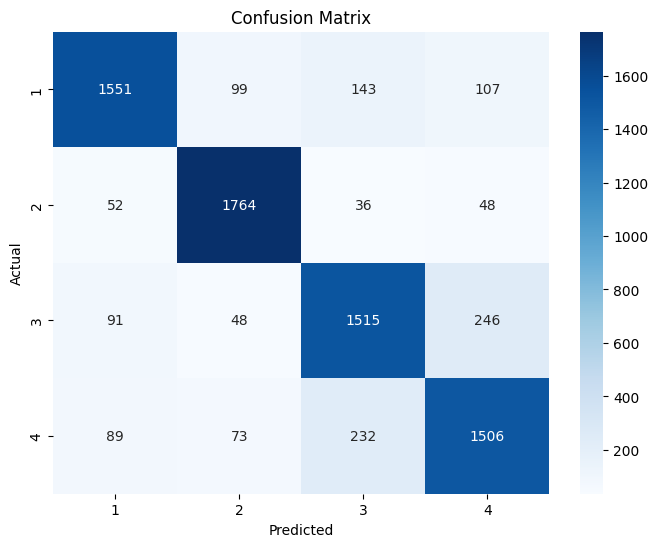

              precision    recall  f1-score   support

           1       0.87      0.82      0.84      1900
           2       0.89      0.93      0.91      1900
           3       0.79      0.80      0.79      1900
           4       0.79      0.79      0.79      1900

    accuracy                           0.83      7600
   macro avg       0.83      0.83      0.83      7600
weighted avg       0.83      0.83      0.83      7600



In [51]:
true_labels, pred_labels = [], []

# Mengumpulkan label sebenarnya dan prediksi
for batch in test_loader:
    input_ids = batch["input_ids"].to(DEVICE)
    labels = batch["label"].to(DEVICE)
    with torch.no_grad():
        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1)
    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(preds.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(true_labels, pred_labels, target_names=[str(c) for c in label_encoder.classes_]))


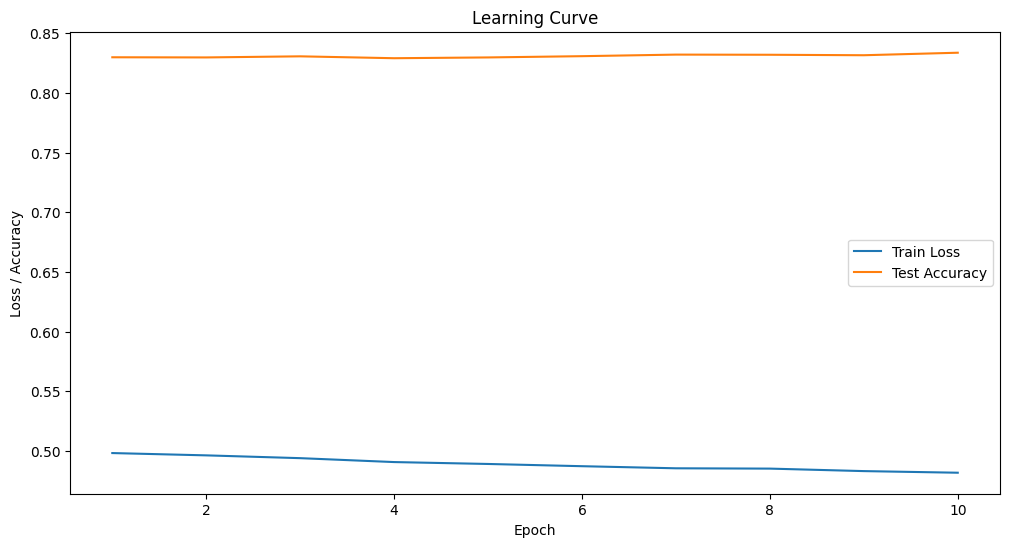

In [50]:
train_losses, test_accuracies = [], []

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    acc = evaluate(model, test_loader)
    train_losses.append(train_loss)
    test_accuracies.append(acc)

plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()


Dari grafik **Learning Curve** yang ditampilkan:

- **Train Loss** cenderung menurun seiring bertambahnya epoch.
- **Test Accuracy** terlihat konstan dan stabil di sekitar 0.83–0.84 tanpa perubahan signifikan.

**Kesimpulan**
- **Tidak ada indikasi overfitting yang signifikan** karena:
  - **Train Loss** menurun secara bertahap, tetapi tidak mendekati nol secara ekstrem.
  - **Test Accuracy** stabil dan tidak menurun drastis, yang berarti model tidak kehilangan kemampuan untuk generalisasi.
- **Catatan tambahan**: Jika model overfit, Anda akan melihat **Train Loss** sangat rendah sementara **Test Accuracy** menurun atau tidak meningkat.

**Saran Analisis Lebih Lanjut**
1. **Dataset Size**: Jika akurasi sudah stabil dan tidak meningkat, mungkin dataset Anda memiliki ukuran yang kecil atau informasi terbatas.
   - Periksa distribusi data, dan jika perlu, tambahkan data baru atau lakukan augmentasi teks.

2. **Model Capacity**: Coba eksperimen dengan:
   - **Ukuran hidden layer** pada model.
   - Tambahkan **regularisasi** seperti `Dropout` (sudah ada di model Anda).

3. **Learning Rate**: Coba tuning `learning rate` lebih lanjut dengan eksperimen untuk memastikan tidak stagnan.

4. **Metrik Lain**: Evaluasi dengan **confusion matrix** atau **classification report** untuk mengetahui kelas mana yang performanya kurang baik.

Jika Anda membutuhkan bantuan untuk analisis lanjutan, beri tahu saya! 😊

In [52]:
# Save Model
torch.save(model.state_dict(), "fasttext_glove_model.pth")
print("Model berhasil disimpan!")

Model berhasil disimpan!
